<a href="https://colab.research.google.com/github/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/Colour%20Image%20Classifier%20CNN%2C%20Computer%20Vision%2C%20CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Colour Image [🌅] Classification CNN, with CIFAR-10** 🔥
**Computer Vision**

* An introduction to CNNs, following Pierian Training's online Udemy course "PyTorch for Deep Learning with Python" bootcamp.


------

## **CIFAR-10 Image Dataset**
[About the dataset](https://en.wikipedia.org/wiki/CIFAR-10)
  * **Via Wikipedia:**
    * The **CIFAR-10 dataset** (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms.
  * It is known as what is called a "toy dataset", because the datasets are used primarily for learning/research and benchmarking in stable conditions in comparison to real-world datasets which can be **noisy**, under constant change and unorganised (impractical when trying to benchmark models against each other).

------------

## **Notebook Objectives**
* This notebook focuses on using a Convolutional Neural Network to classify 32x32 pixel images in colour, making the input a 3-colour channel (RGB) tensor.
* There are **10 classes** to classify from:
  * Airplane
  * Car
  * Bird
  * Cat
  * Deer
  * Dog
  * Frog
  * Horse
  * Ship
  * Truck


    A Multiclass Image Classification problem

#### **Results from Model Study**
| **Metric** |  | **CNN Model** |
| --- | --- | --- |
| Percentage Accuracy | | ~61% |
| No. Parameters | | ~81k |
| No. Epochs |  | 10 |
| Training Time |  | ~8 Mins |
| Criterion |  | Cross Entropy |
| Optimiser |  | Adam |
| Output Activation Function |  | Log Softmax, dim=1 |
| Convolutional Layers | | 2 |
| Max Pooling Layers |  | 2 |
| Fully Connected Layers |  | 3 |
| Ran Locally  |  | No |
| Ran on Cloud  |  | Yes |
| Cloud Resource  |  | Google Colab |
| Runtime Type  |  | Python 3 |
| Hardware Accelerator  |  | CPU |
| Cloud System RAM |  | 12.7 GB |
| Cloud Disk |  |  107.7 GB |

# **1. Import Packages**

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from pathlib import Path
import seaborn as sns

# machine learning packages
from sklearn.metrics import confusion_matrix

# deep learning packages
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision, torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset

# **2. Load Data**

## **Load Data as Tensor Objects**

In [2]:
transform = transforms.ToTensor()

In [3]:
# datasets.CIFAR10

In [4]:
# error handling for downloading data to a working dir (Training Set)
try:
  train_data = datasets.CIFAR10(root='/content',train=True,download=True,transform=transform) # for running in colab
except Exception as e:
  print(f'Error downloading CIFAR10 dataset to /content: {e}')
  print(f'Attempting to save to desktop instead...')

  # get path to user desktop
  desk_path = str(Path.home() / "Desktop")

  # save the dataset to the desktop
  train_data = datasets.CIFAR10(root=desk_path,train=True,download=True,transform=transform)
  print(f'Train Dataset saved to: {desk_path}')

100%|██████████| 170M/170M [00:11<00:00, 15.5MB/s]


In [5]:
# error handling for downloading data to a working dir (Test Set)
try:
  test_data = datasets.CIFAR10(root='/content',train=False,download=True,transform=transform) # for running in colab
except Exception as e:
  print(f'Error downloading CIFAR10 dataset to /content: {e}')
  print(f'Attempting to save to desktop instead...')

  # get path to user desktop
  desk_path = str(Path.home() / "Desktop")

  # save the dataset to the desktop
  test_data = datasets.CIFAR10(root=desk_path,train=False,download=True,transform=transform)
  print(f'Test Dataset saved to: {desk_path}')

### **Test That Data Loads**

In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: ToTensor()

### **Create Data Loaders**

In [8]:
# create data loaders for dataset
torch.manual_seed(101)

# create dataloaders for the datasets
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### **View a Snippet of Images**

In [10]:
# view a batch of images
for images, labels in train_loader:
  break

In [11]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

In [12]:
images[0].shape

torch.Size([3, 32, 32])

Label: [1 5 8 1 6 1 6 3 7 9]
Class:   car   dog  ship   car  frog   car  frog   cat horse truck


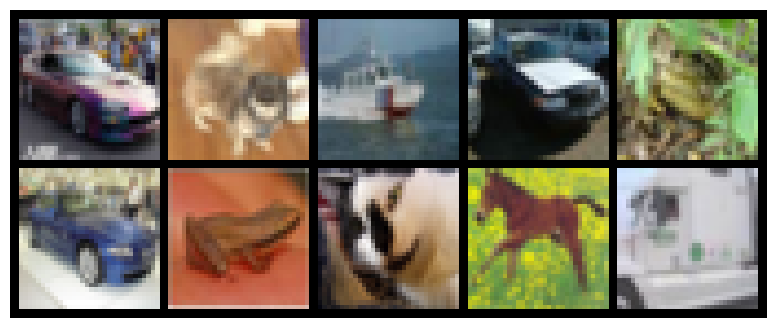

In [13]:
# print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

# show the 1st 10 images
im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.axis('off')
plt.show()

# **3. Define The Model**

In [29]:
class CNN(nn.Module):

  def __init__(self):

    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,1) # input size, output size, kernel size, stride
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(6*6*16,120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10) # 10 output classes

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,16*6*6)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [15]:
images[0].shape

torch.Size([3, 32, 32])

In [30]:
# instantiate the cnn model

torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
for param in model.parameters():
  print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [32]:
# number of parameters including the bias terms
cnn_param_numel = sum([450,
6,
864,
16,
69120,
120,
10080,
84,
840,
10])

print(f'This CNN has {cnn_param_numel} parameters in total!')

This CNN has 81590 parameters in total!


## **Define The Error Measurement Method & Optimisation Algorithm**

In [33]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **4. Model Training**

In [34]:
start_time = time.time()

# trackers
n = 10
epochs = n

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop, epochs
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  # train batches
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1

    # apply the model to make predictions
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1]
    # true = 1, false = 0
    batch_corr = (predicted == y_train).sum()
    trn_corr+=batch_corr

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print every 1000 images
    accuracy = trn_corr.item()*100/(10*b)
    if b%1000==0:
      print(f'Epoch: {i:2}  Batch: {b:4} [{10*b:6}/50000]   Loss: {loss.item():10.8f}  Accuracy: {accuracy:7.3f}%')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test batches
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):

      # apply the model
      y_val = model(X_test)

      # trackers
      predicted = torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


# how long did training take
current_time = time.time()
total = current_time - start_time
print(f'\nDuration: {total/60:.0f} minutes')


Epoch:  0  Batch: 1000 [ 10000/50000]   Loss: 2.08479738  Accuracy:  26.310%
Epoch:  0  Batch: 2000 [ 20000/50000]   Loss: 1.86035669  Accuracy:  32.210%
Epoch:  0  Batch: 3000 [ 30000/50000]   Loss: 0.98036224  Accuracy:  35.597%
Epoch:  0  Batch: 4000 [ 40000/50000]   Loss: 1.17383957  Accuracy:  37.740%
Epoch:  0  Batch: 5000 [ 50000/50000]   Loss: 1.40289986  Accuracy:  39.556%
Epoch:  1  Batch: 1000 [ 10000/50000]   Loss: 1.33619356  Accuracy:  48.580%
Epoch:  1  Batch: 2000 [ 20000/50000]   Loss: 1.24109256  Accuracy:  49.155%
Epoch:  1  Batch: 3000 [ 30000/50000]   Loss: 1.21758509  Accuracy:  49.780%
Epoch:  1  Batch: 4000 [ 40000/50000]   Loss: 0.93761617  Accuracy:  50.110%
Epoch:  1  Batch: 5000 [ 50000/50000]   Loss: 1.86942172  Accuracy:  50.504%
Epoch:  2  Batch: 1000 [ 10000/50000]   Loss: 1.68727148  Accuracy:  53.850%
Epoch:  2  Batch: 2000 [ 20000/50000]   Loss: 1.30205429  Accuracy:  53.990%
Epoch:  2  Batch: 3000 [ 30000/50000]   Loss: 1.43821609  Accuracy:  54.600%

# **5. Save The Model in `cd`**

In [35]:
# save the model
torch.save(model.state_dict(), 'CIFAR-10-cnn-model.pt')

# **6. Plot The Model Loss & Accuracy**

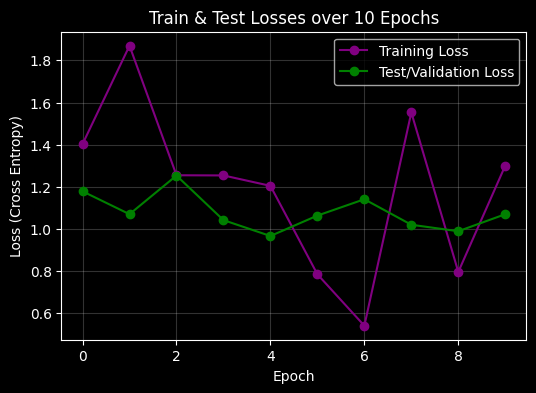

In [36]:
# test and train loss over 10 epochs
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
np_train_losses = [loss.detach().cpu().numpy() for loss in train_losses]
np_test_losses = [loss.detach().cpu().numpy() for loss in test_losses]

plt.plot(np_train_losses,
         marker='o',
         color='purple',
         label='Training Loss')
plt.plot(test_losses,
         marker='o',
         color='green',
         label='Test/Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Train & Test Losses over 10 Epochs')
plt.legend()
plt.grid(alpha=.2)
plt.show()

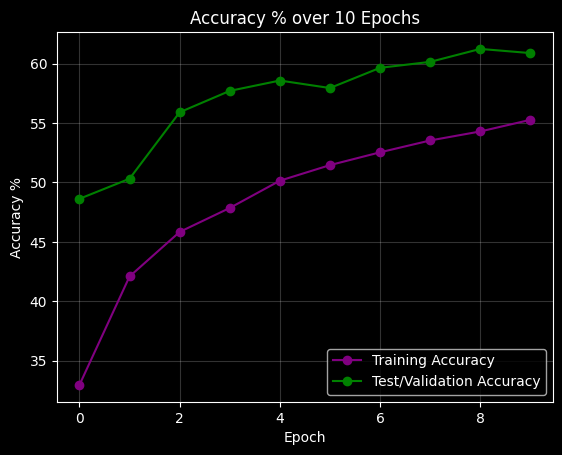

In [38]:
# accuracy over 10 epochs
plt.plot([t/600 for t in train_correct],
         marker='o',
         color='purple',
         label='Training Accuracy')
plt.plot([t/100 for t in test_correct],
         marker='o',
         color='green',
         label='Test/Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy % over 10 Epochs')
plt.legend(loc='lower right')
plt.grid(alpha=.2)
plt.show()

# **7. Evaluate Test Data**

In [43]:
# how many predictions were correct?
print('There were',test_correct[-1].item(),'correct predictions!')
total = test_correct[-1].item()
calc_perc = test_correct[-1].item()/len(test_data)*100
print(f'The model is {calc_perc:.0f}% accurate!')

There were 6088 correct predictions!
The model is 61% accurate!


#### **Results from Model Study**
| **Metric** |  | **CNN Model** |
| --- | --- | --- |
| Percentage Accuracy | | ~61% |
| No. Parameters | | ~81k |
| No. Epochs |  | 10 |
| Training Time |  | ~8 Mins |
| Criterion |  | Cross Entropy |
| Optimiser |  | Adam |
| Output Activation Function |  | Log Softmax, dim=1 |
| Convolutional Layers | | 2 |
| Max Pooling Layers |  | 2 |
| Fully Connected Layers |  | 3 |
| Ran Locally  |  | No |
| Ran on Cloud  |  | Yes |
| Cloud Resource  |  | Google Colab |
| Runtime Type  |  | Python 3 |
| Hardware Accelerator  |  | CPU |
| Cloud System RAM |  | 12.7 GB |
| Cloud Disk |  |  107.7 GB |

# **8. Display Confusion Matrix**
*This code is from the lecture notebook*

* This maps predictions against the true labels, which requires a run throught the entire test set.
  * A heatmap helps contextualise where the preditions performed well and where it struggled and by how much - more intuitively.
  * The heatmap shows that:
    * Dogs are often mixed up with cats
    * Birds were often misclassified as deer
    * Trucks were often confused with cars
    * Planes were often confused with ships
    * [...]

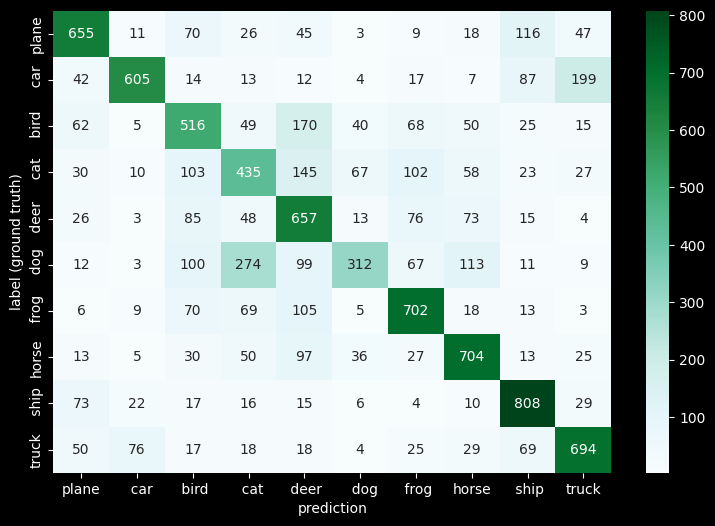

In [45]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();